# Plot heatmap and logo

## Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from katlas.core import *
from katlas.plot import *

from scipy.stats import spearmanr, pearsonr

import os
from PIL import Image
from tqdm import tqdm


In [ ]:
def plot_count(df_k,title):
    # Get value counts
    source_counts = df_k.source.replace({'pplus':'PP','large_scale':'LS'}).value_counts()
    plt.figure(figsize=(7,1))

    source_counts.plot(kind='barh', stacked=True, color=['darkred', 'darkblue'])
    # Annotate with the actual values
    for index, value in enumerate(source_counts):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')

    plt.xlabel('Count')
    plt.title(title)

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

## Load data

In [ ]:
df = Data.get_ks_dataset()
df['SUB'] = df.substrate.str.upper()

In [ ]:
info = Data.get_kinase_info().query('pseudo=="0"')

In [ ]:
# It only contains kinase on the tree
cnt = df.kinase_paper.value_counts()

In [ ]:
ST = info[info.group!="TK"].kinase

In [ ]:
df[df.kinase_paper.isin(ST)].kinase_paper.value_counts()[10:20]

NEK6     950
PLK1     943
CK2A1    919
P38D     907
DYRK2    907
HGK      902
TTBK1    896
MST3     890
MST1     884
IKKE     880
Name: kinase_paper, dtype: int64

In [ ]:
cnt = cnt[cnt>100]

## Generate example figures

In [ ]:
def plot_heatmap2(matrix, title, figsize=(6,10), label_size=20):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, cmap='binary', annot=False,cbar=False)
    plt.title(title,fontsize=label_size)
        # Set the font size for the tick labels
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
kinase_list = ['SRC','ABL1','ERK2','PKACA']

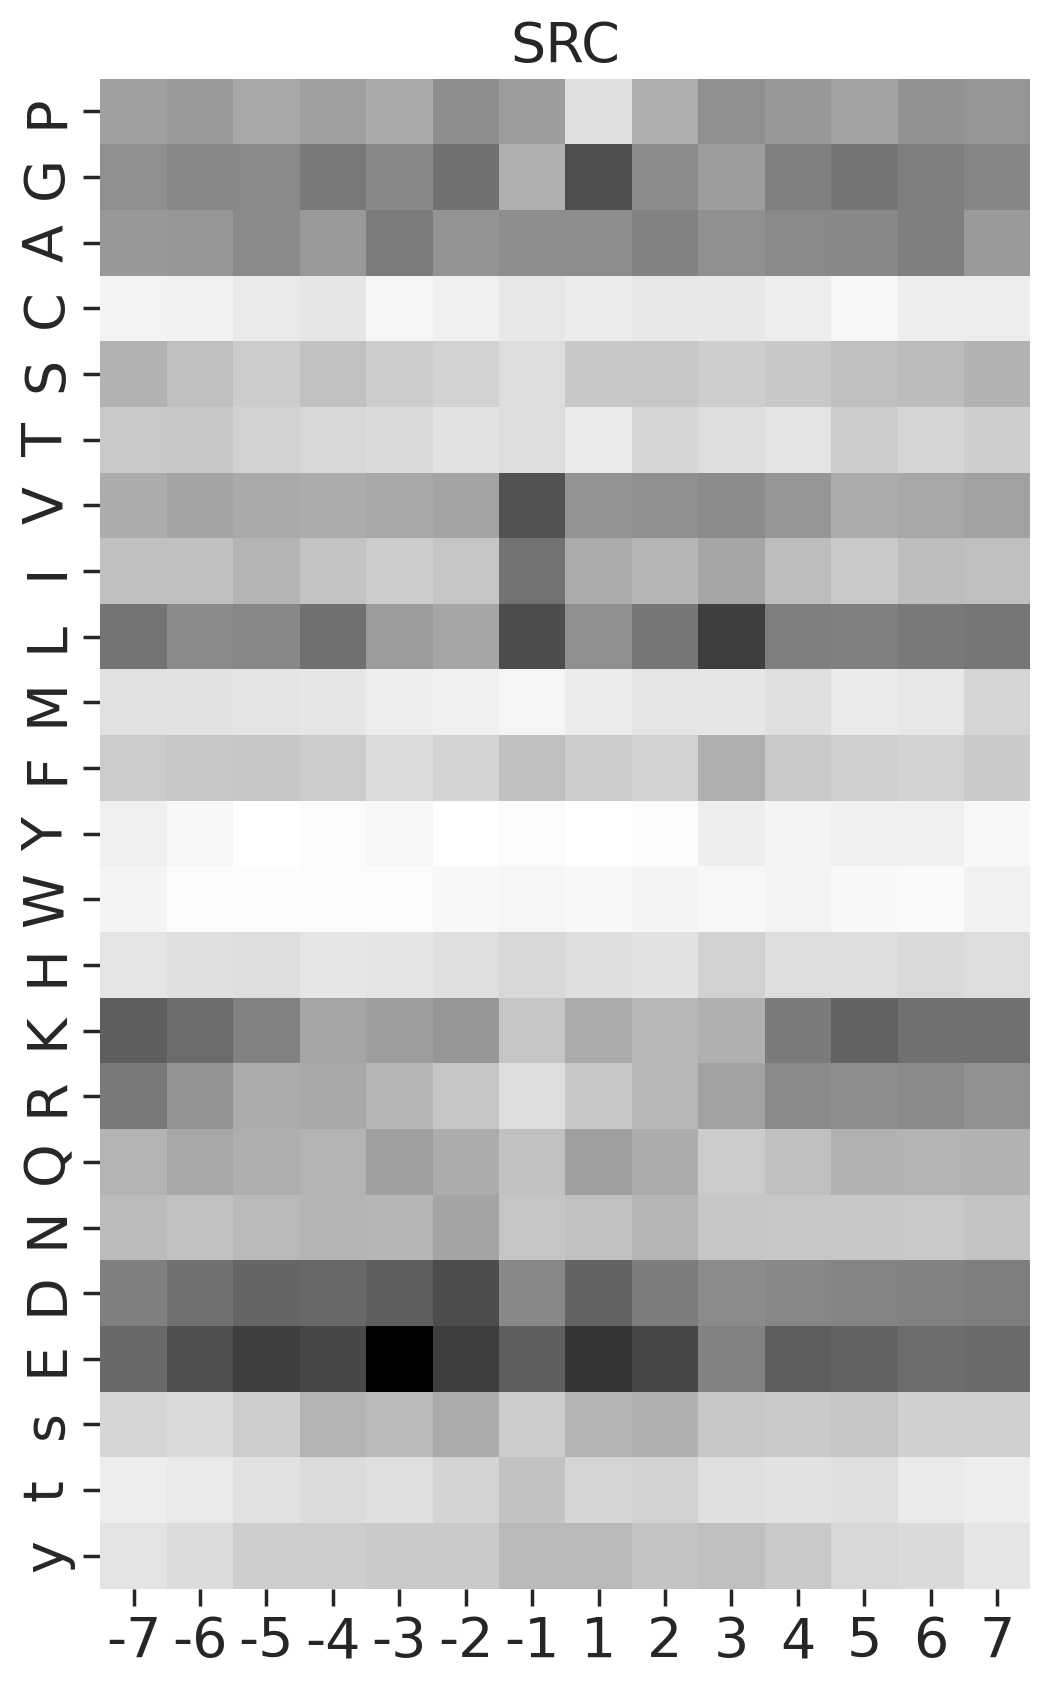

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

for k in kinase_list:
    df_k = df.query(f'kinase=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()

    paper,full = get_freq(df_k)

    plot_heatmap2(full.drop(columns=[0]),f'{k}',figsize=(6,10))
    plt.show()
    plt.close()
        
    break

    # if you want to generate and save all of figures, uncomment below
    # plt.savefig(f'fig/{k}.png',bbox_inches='tight', pad_inches=0.3)
    # plt.close()

## Generate all figures

Uncomment plt.savefig to save figures

  0%|          | 0/289 [00:00<?, ?it/s]

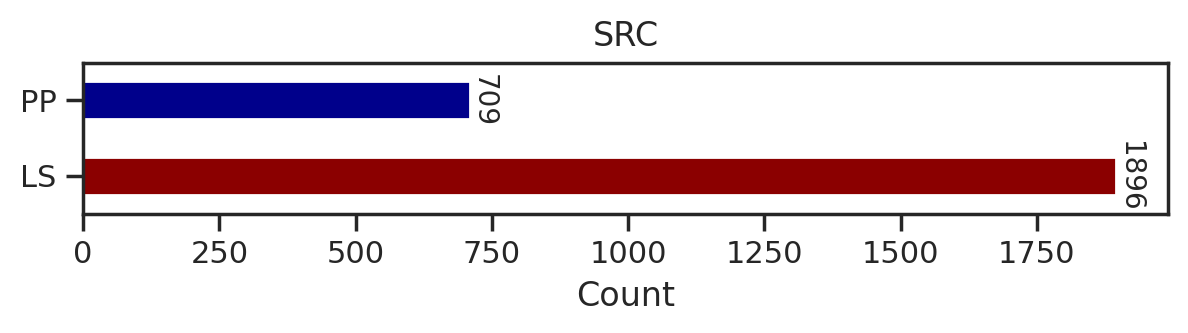

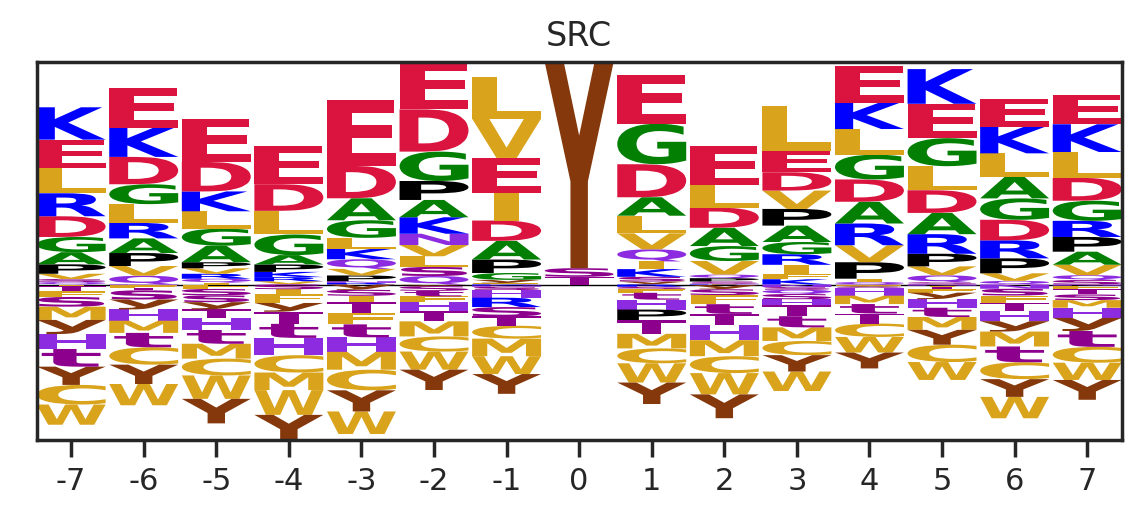

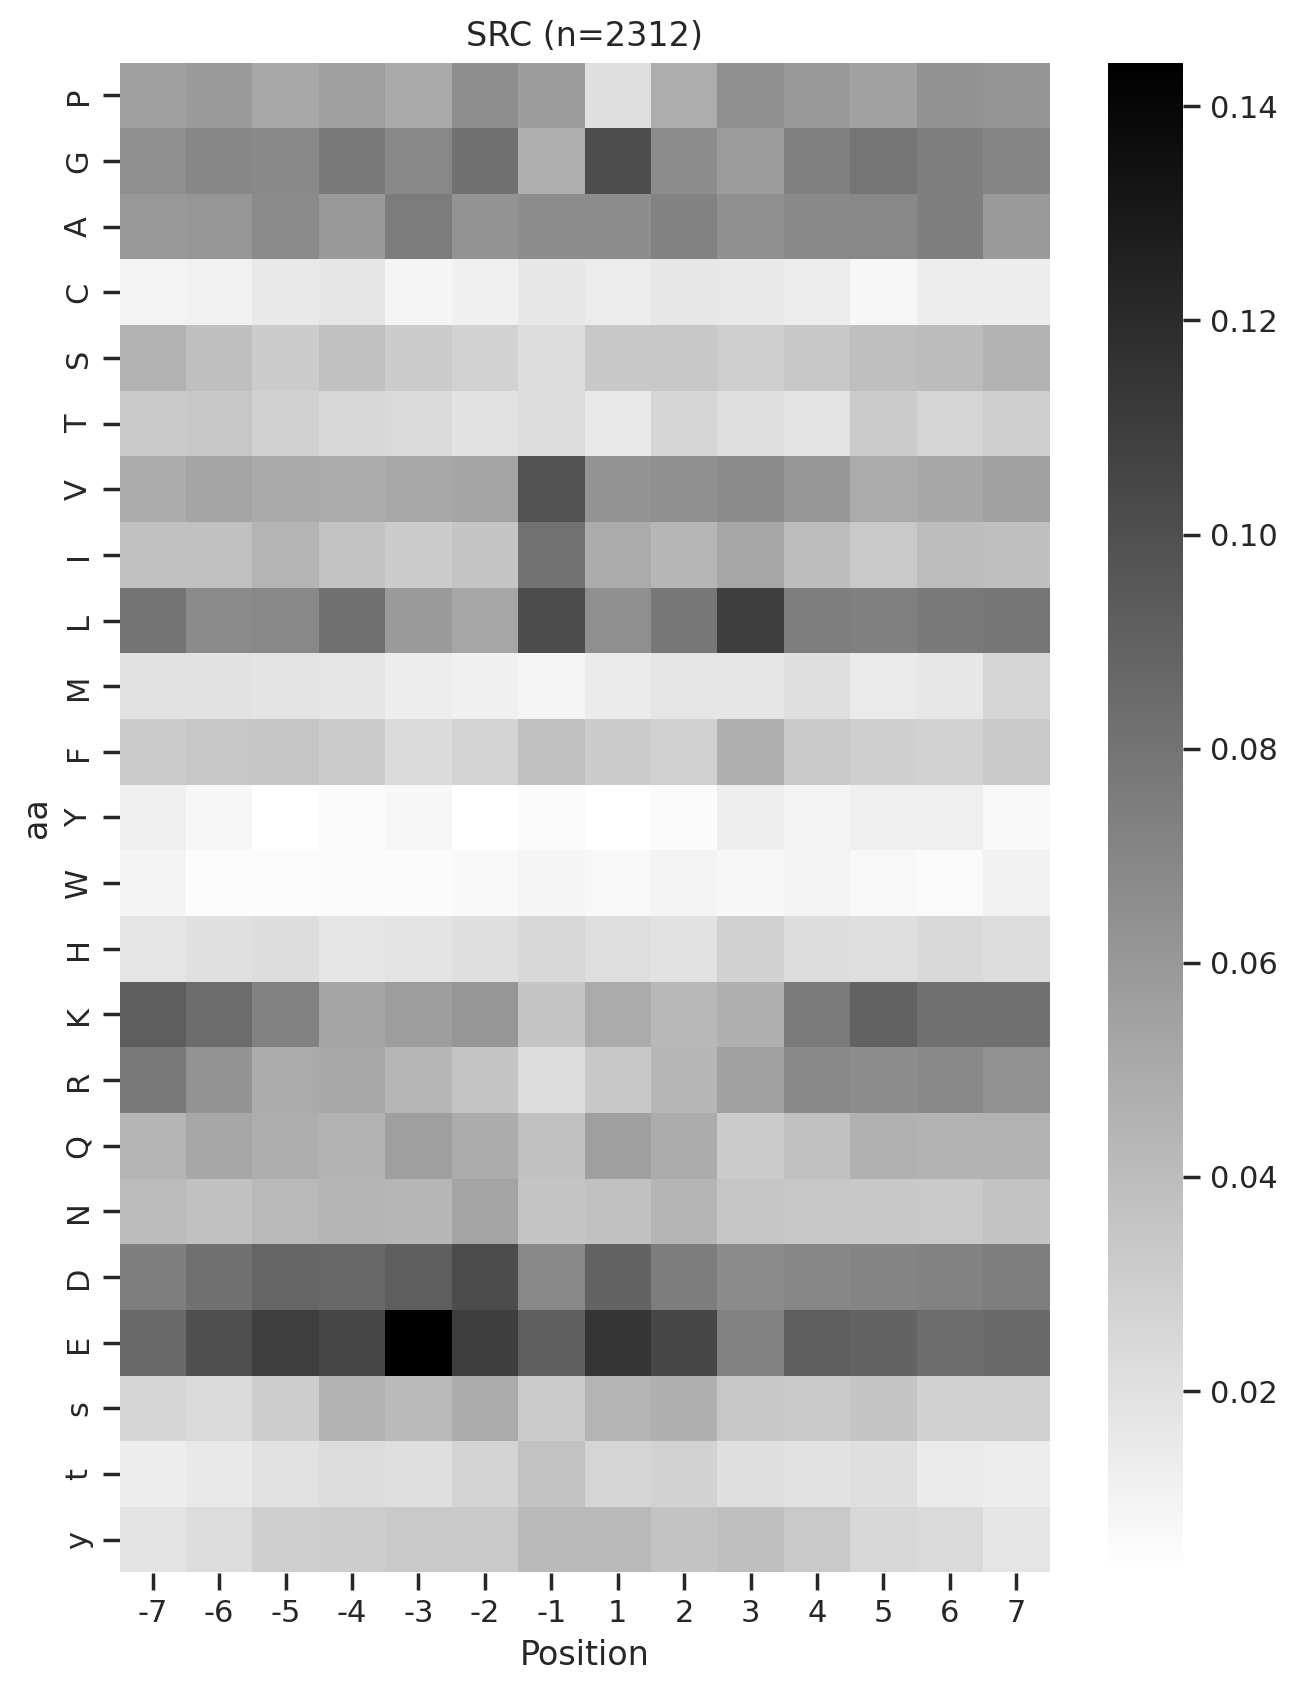

  0%|          | 0/289 [00:02<?, ?it/s]


In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

for k in tqdm(cnt.index,total=len(cnt)):
    
    df_k = df.query(f'kinase=="{k}"')
    
    plot_count(df_k,k)
    # plt.savefig(f'fig/count/{k}.png',bbox_inches='tight', pad_inches=0.1)
    plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()
    
    
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    paper,full = get_freq(df_k)

    get_logo2(full, k)
    # plt.savefig(f'fig/logo/{k}.png',bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()

    plot_heatmap(full.drop(columns=[0]),f'{k} (n={len(df_k)})',figsize=(7.5,10))
    # plt.savefig(f'fig/heatmap/{k}.png',bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    # break
    break

## Combine figures for pdf

In [ ]:
def combine_images_vertically(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    total_width = max(image.width for image in images)
    total_height = sum(image.height for image in images)

    combined_image = Image.new('RGBA', (total_width, total_height))

    y_offset = 0
    for image in images:
        combined_image.paste(image, (0, y_offset), image)
        y_offset += image.height

    combined_image.save(output_path)

Uncomment below to run

In [ ]:
# folders = ["fig/count", "fig/logo", "fig/heatmap"]
# for k in tqdm(cnt.index,total=len(cnt)):
#     filename = f"{k}.png"
#     image_paths = [os.path.join(folder, filename) for folder in folders]
#     output_path = f"fig/combine/{k}.png"
    
#     combine_images_vertically(image_paths, output_path)
#     # break

## Get PSSM data of CDDM

In [ ]:
for i,k in enumerate(cnt.index):
    
    df_k = df.query(f'kinase=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    paper,full = get_freq(df_k)

    melt = full.drop(columns = [0]).reset_index().melt(id_vars=['aa'], value_name=k, var_name='Position')
    melt['substrate']=melt['Position'].astype(str)+ melt['aa']

    position_0 = full[0][['s','t','y']].reset_index().rename(columns={0:k})
    position_0['substrate'] = '0'+position_0['aa']

    if i ==0:
        first = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
    else:
        k = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
        data = pd.concat([first,k],axis=1)
        first = data.copy()
    
    # break

In [ ]:
data = data.T

data.index = data.index.rename('kinase')

To save

In [ ]:
# data.to_csv('supp/CDDM.csv')

# data.to_parquet('ks_main.parquet')

## Get specialized CDDM data for all-capital substrates
>combine s,t,y to S,T,Y

In [ ]:
# List of suffixes
suffixes = ['S', 'T', 'Y']

for suffix in suffixes:
    for i in range(-7, 8):  # looping from -7 to 7
        if i == 0:  # Skip 0
            continue
        
        upper_col = f"{i}{suffix}"  # e.g., -7S
        lower_col = f"{i}{suffix.lower()}"  # e.g., -7s
        data[upper_col] = data[upper_col] + data[lower_col]
        data.drop(lower_col, axis=1,inplace=True)  # Drop the lowercase column after combining

In [ ]:
data.columns[data.columns.str.contains('S')]

Index(['-7S', '-6S', '-5S', '-4S', '-3S', '-2S', '-1S', '1S', '2S', '3S', '4S',
       '5S', '6S', '7S'],
      dtype='object', name='substrate')

In [ ]:
# make sure the "s" in positions other than 0 is deleted from the columns
data.columns[data.columns.str.contains('s')]

Index(['0s'], dtype='object', name='substrate')

In [ ]:
# Make sure very position's sum is 1
data.loc[:,data.columns.str.contains('-7')].sum(1).sort_values()

kinase
DDR2      1.0
NEK11     1.0
MSK1      1.0
TEK       1.0
NIM1      1.0
         ... 
CAMK2G    1.0
PKG2      1.0
MELK      1.0
NEK1      1.0
TLK2      1.0
Length: 289, dtype: float64

In [ ]:
data = data.rename(columns={'0s':'0S','0t':'0T','0y':'0Y'})

In [ ]:
data.index = data.index.rename('kinase')

To save

In [ ]:
# data.to_parquet('ks_main_upper.parquet')
data.to_csv('supp/CDDM_upper.csv')

## Plot other kinases (mutated, lipid kinase, isoforms)
> kinases not on kinome tree

In [ ]:
cnt_other = df.query('on_tree==0').kinase.value_counts()

cnt_other = cnt_other[cnt_other>100]

In [ ]:
others = cnt_other.index.tolist()+['LYN','ABL1','RET','FGFR3','PDGFRA','ALK',
                          'EGFR','KIT','MET','PKCB','BRAF','PKG1'] # BRAF is less than 100

Uncheck savefig to save figures

  0%|          | 0/36 [00:00<?, ?it/s]

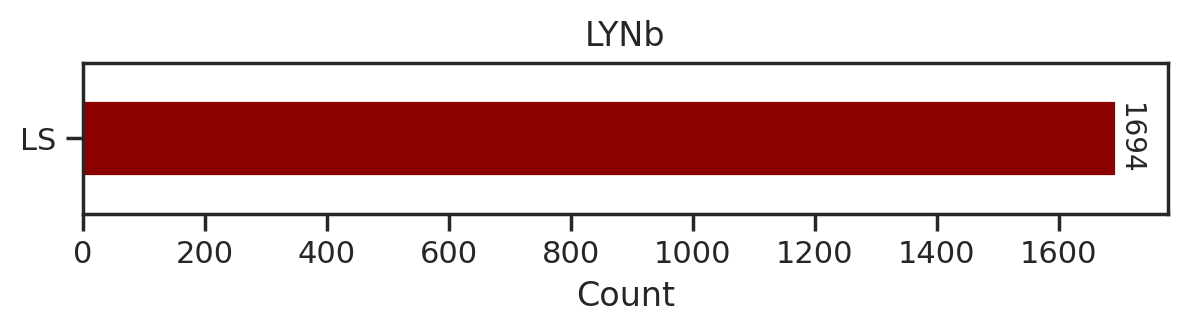

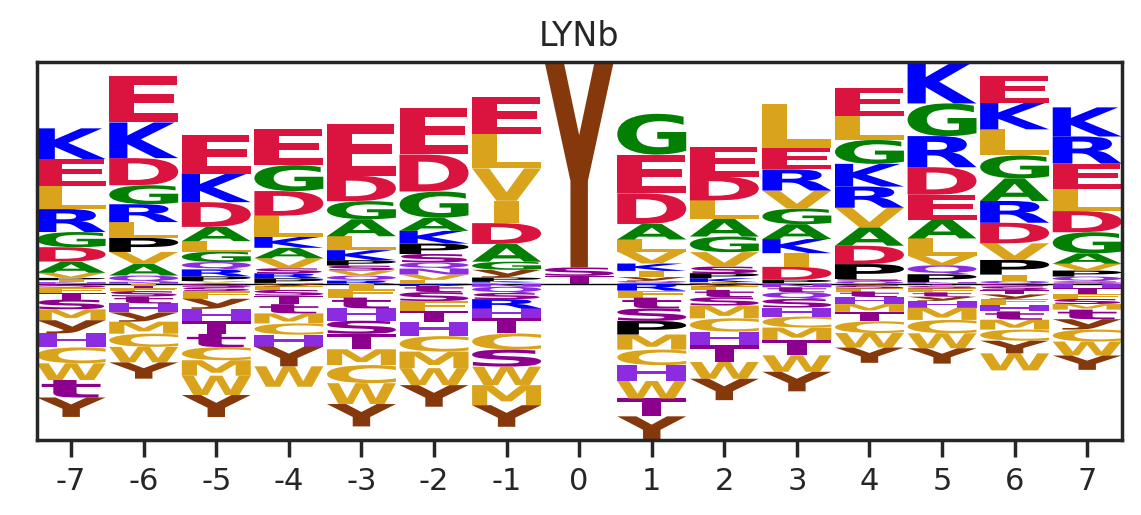

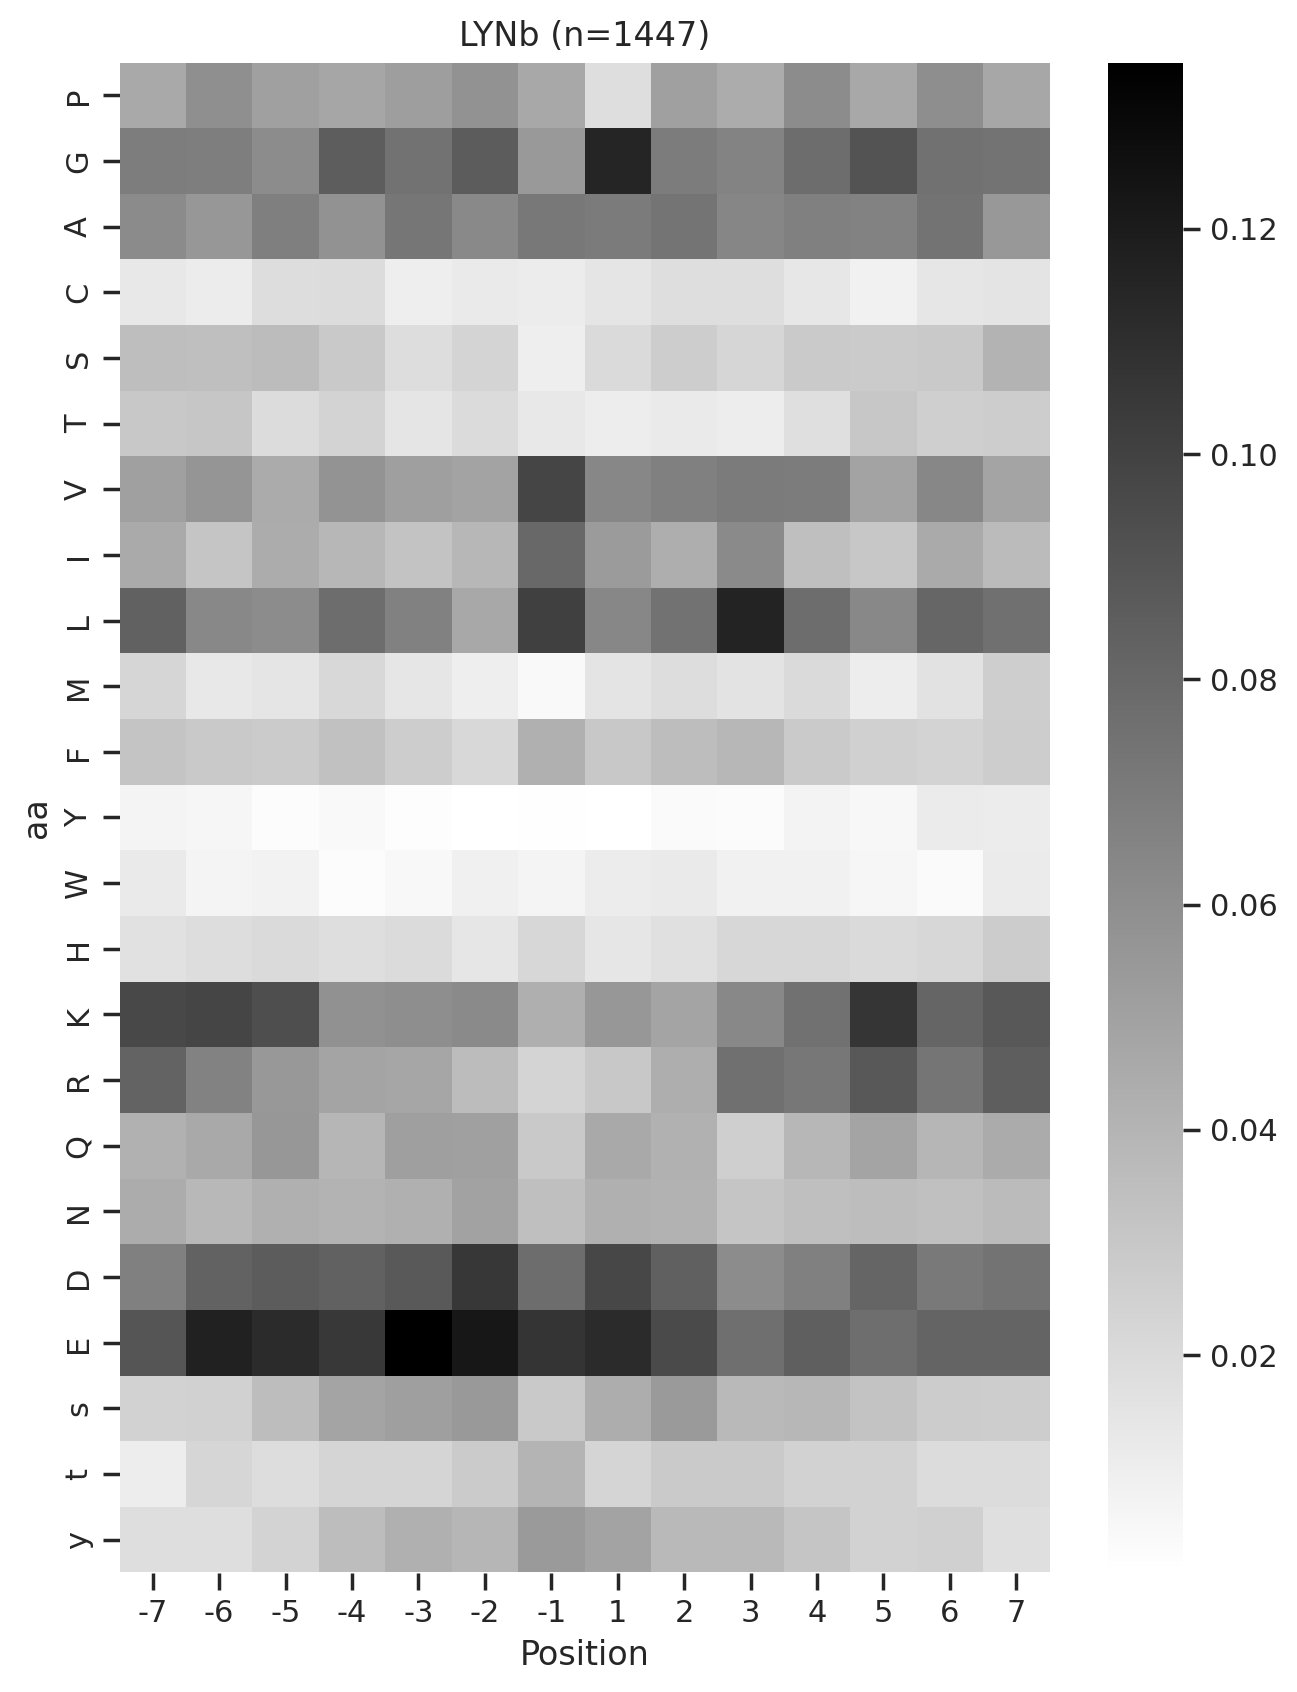

  0%|          | 0/36 [00:01<?, ?it/s]


In [ ]:
for k in tqdm(others,total=len(others)):
    df_k = df.query(f'kinase=="{k}"')
    
    plot_count(df_k,k)
    # plt.savefig(f'fig_others/count/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.1)
    plt.show() # if visualize in jupyter notebook, uncheck the savefig
    plt.close()
    
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    paper,full = get_freq(df_k)
    
    get_logo2(full,k)
    # plt.savefig(f'fig_others/logo/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()
    
    plot_heatmap(full.drop(columns=[0]),f'{k} (n={len(df_k)})',figsize=(7.5,10))
    # plt.savefig(f'fig_others/heatmap/{k.replace("/", "_")}.png',bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
    break

## Combine the figures for pdf

Uncomment below to run

In [ ]:
# folders = ["fig_others/count", "fig_others/logo", "fig_others/heatmap"]
# for k in tqdm(others,total = len(others)):
#     k = k.replace("/", "_")
    
#     filename = f"{k}.png"
    
#     image_paths = [os.path.join(folder, filename) for folder in folders]
    
#     output_path = f"fig_others/combine/{k}.png"
    
#     combine_images_vertically(image_paths, output_path)
#     # break

## Get the PSSMs of other kinases

In [ ]:
for i,k in enumerate(others):
    df_k = df.query(f'kinase=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    paper,full = get_freq(df_k)
    
    melt = full.drop(columns = [0]).reset_index().melt(id_vars=['aa'], value_name=k, var_name='Position')
    melt['substrate']=melt['Position'].astype(str)+ melt['aa']

    position_0 = full[0][['s','t','y']].reset_index().rename(columns={0:k})
    position_0['substrate'] = '0'+position_0['aa']

    if i ==0:
        first = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
    else:
        k = pd.concat([melt,position_0])[['substrate',k]].set_index('substrate')
        data = pd.concat([first,k],axis=1)
        first = data.copy()

In [ ]:
data = data.T

data.index = data.index.rename('kinase')

To save:

In [ ]:
# data.to_csv('supp/CDDM_others.csv')

# data.to_parquet('ks_others.parquet')